In [1]:
%load_ext autoreload
%autoreload 2

In [62]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera
from IPython.display import HTML

import importlib
import warnings
import numpy as np
import pandas as pd
import copy
import random
from tslib.src import tsUtils
from tslib.tests import testdata
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import hdbscan
%matplotlib inline

In [3]:
import matplotlib.animation as animation
Writer = animation.FFMpegWriter(fps=30, codec='libx264')  #or 
Writer = animation.FFMpegWriter(fps=20, metadata=dict(artist='Me'), bitrate=1800)

In [ ]:
matplotlib.animation.MovieWriter(fps=5, codec=None, bitrate=None, extra_args=None, metadata=None)

## Pre-processing data

In [11]:
#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

In [4]:
# plt.rcParams["animation.writer"] = ''

In [5]:
#Load and clean all raw data
from load_and_clean import *
us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple, google_social = load_clean('mobility')
sd_data = load_clean('IHME intervention')
all_population = load_clean('population')

In [6]:
#Filter data 
# This part might be to split and explain
from filter_data import *
rolling_average_duration = 7

global_deaths_filtered = create_filtered_data(global_deaths, 500 )
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths], axis=1)  
all_data = pd.concat([all_data, uscounties_deaths], axis=1)

all_data_daily = create_rolling_data(all_data, rolling_average_duration)

all_data_cases = pd.concat([global_cases, uscases], axis=1) 
all_data_cases = pd.concat([all_data_cases, uscounties_cases], axis=1)

all_data_cases_daily = create_rolling_data(all_data_cases, rolling_average_duration)


newdf=filter_data_by_intervention(usdeaths, educational_distancing)
newdf_global=filter_data_by_intervention(global_deaths, educational_distancing)
newdf_uscounties=filter_data_by_intervention(uscounties_deaths, educational_distancing)

daily_global = create_rolling_data(newdf_global, rolling_average_duration)
daily_us = create_rolling_data(newdf, rolling_average_duration)
daily_uscounties = create_rolling_data(newdf_uscounties,rolling_average_duration)

cases_intervention_adjusted = filter_data_by_intervention(all_data_cases, educational_distancing)
deaths_intervention_adjusted = filter_data_by_intervention(all_data, educational_distancing)
deaths_intervention_adjusted_google =  filter_data_by_intervention(all_data, google_social)

cases_intervention_adjusted_daily = cases_intervention_adjusted.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]
deaths_intervention_adjusted_daily = deaths_intervention_adjusted.diff().iloc[1:,:].rolling(rolling_average_duration).mean().iloc[rolling_average_duration-1:,:]

cases_intervention_adjusted_daily.index = cases_intervention_adjusted_daily.index-rolling_average_duration
deaths_intervention_adjusted_daily.index = deaths_intervention_adjusted_daily.index-rolling_average_duration


last date
Exceptions are []


c:\users\wangy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':
c:\users\wangy\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


## Find the target areas

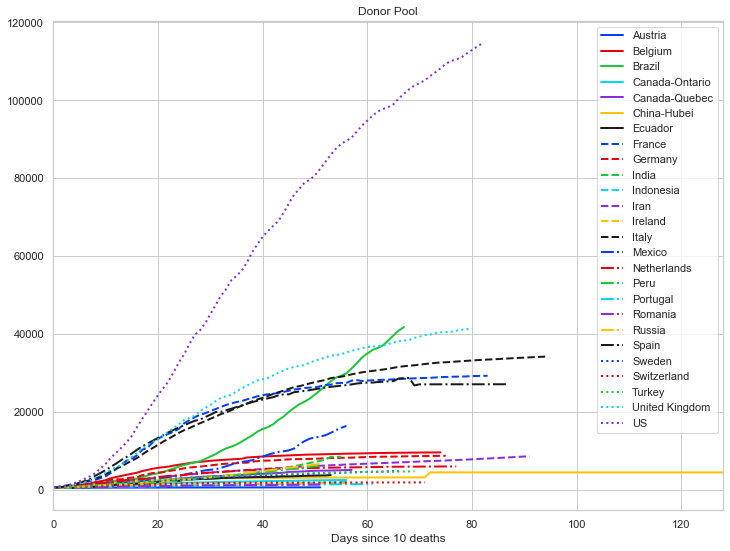

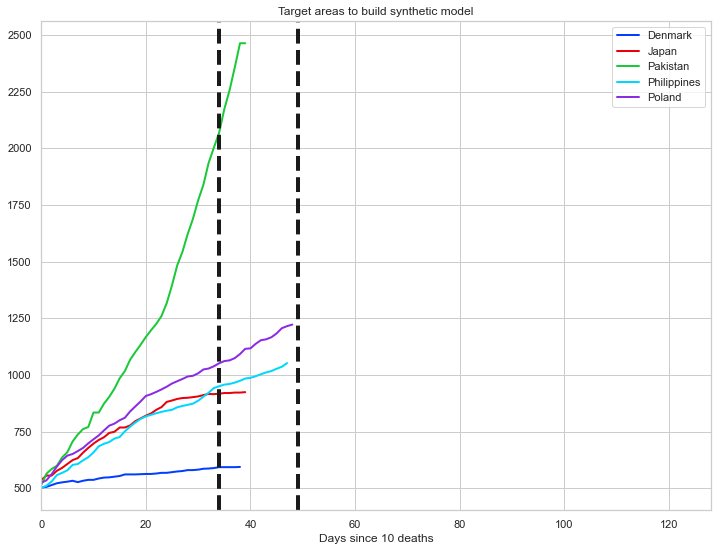

In [7]:
plt.rcParams['figure.figsize'] = (12.0, 9.0)
plt.rcParams.update({'font.size': 8})


sizes = global_deaths_filtered.apply(pd.Series.last_valid_index)  
low_thresh=35
threshold=50
donorlpool = list(sizes[sizes>threshold].index)

global_deaths_filtered[donorlpool].plot( grid=True, title='Donor Pool', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.show()

prediction_states = list(sizes[(sizes>low_thresh) & (sizes<threshold)].index)
global_deaths_filtered[prediction_states].plot(grid=True, title='Target areas to build synthetic model', linewidth=2)
plt.xlabel('Days since 10 deaths')
plt.axvline(x=low_thresh-1, color='k', linestyle='--', linewidth=4)
plt.axvline(x=threshold-1, color='k', linestyle='--', linewidth=4)
plt.show()

## Apply synthetic control to New York - what if shutdown was carried out early

In [128]:

targets = ['New York']# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 3
lambdas = [1]


for target in targets:
    fig = plt.figure(figsize=(15,6))
    camera = Camera(fig)
    
    
    for i in range(1,15):

        temp_df = filter_data_by_intervention(all_data_daily[[target]], educational_distancing, i)

        return_value = synth_control_predictions([pd.concat([deaths_intervention_adjusted_daily,temp_df], axis=1)], 60,22, "7-day moving average of daily deaths", singVals, ylimit=[], 
                                   savePlots=False, do_only=[target+" -%s"%i], showstates=12, 
                                   exclude=[target, 'China-Hubei'], showDonors=False, animation = camera, silent=True, showPlots=True, error_thresh=3)

    
    animation = camera.animate()
plt.close('all')
# HTML(animation.to_jshtml())
animation.save('New York new.mp4')
HTML(animation.to_html5_video())

## Apply synthetic control to reopen states - what if the states have not been reopened?

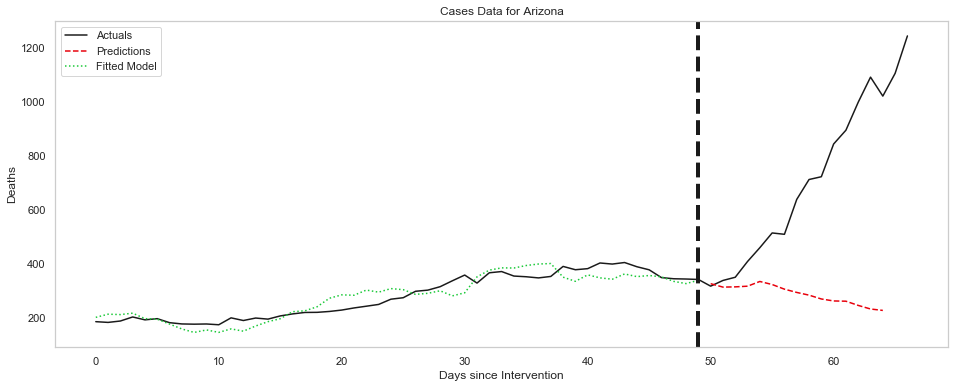

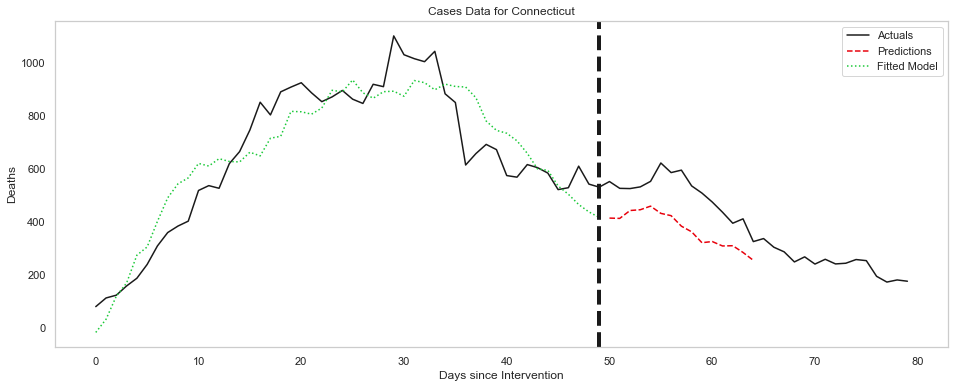

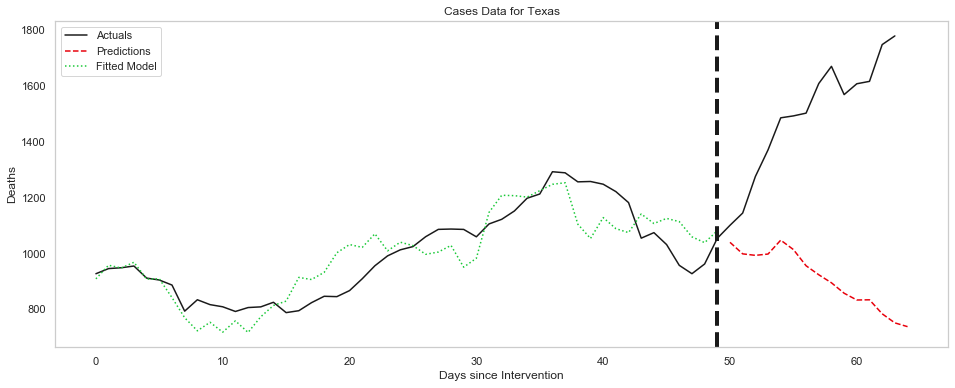

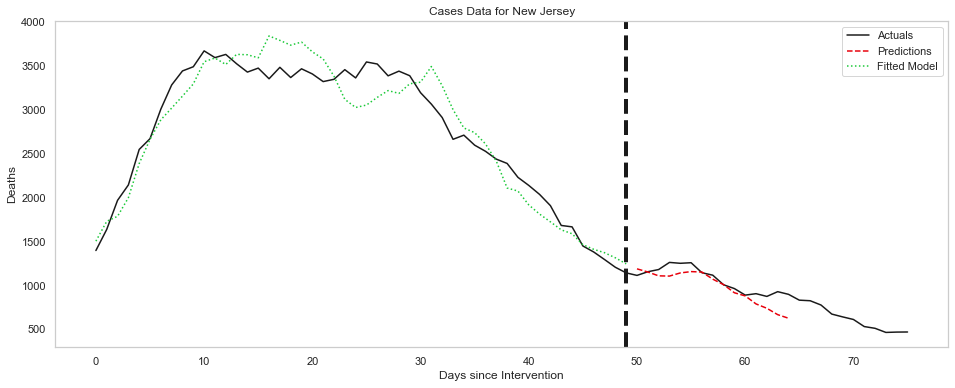

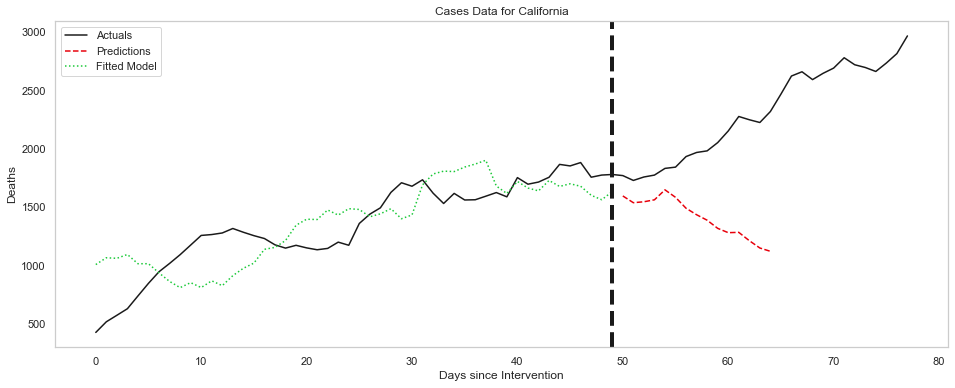

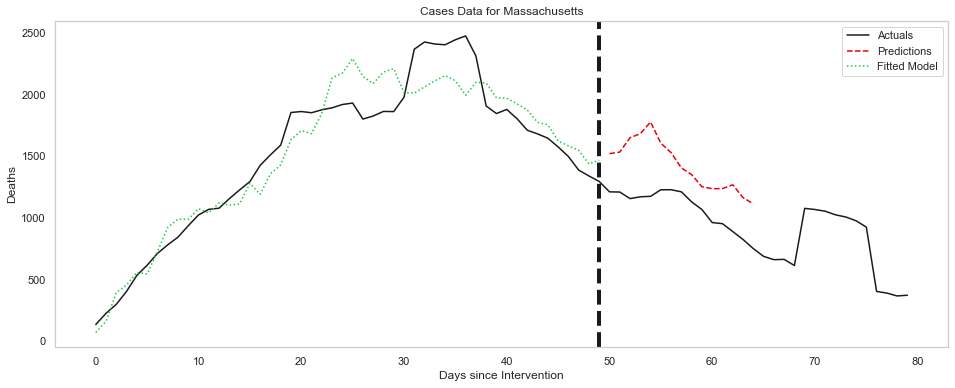

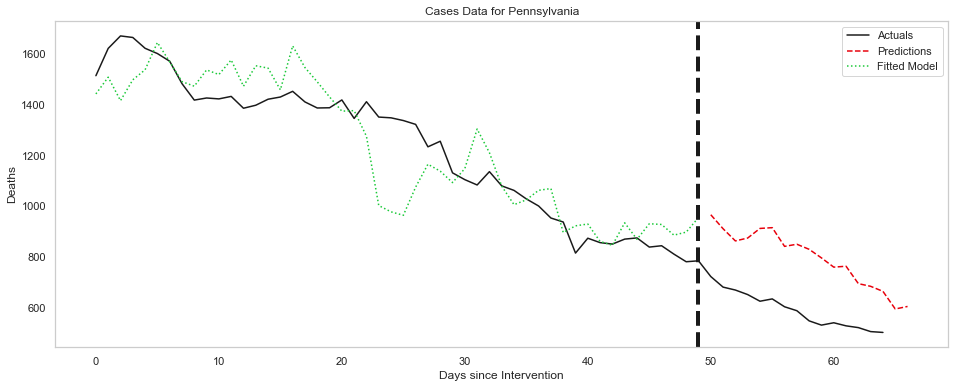

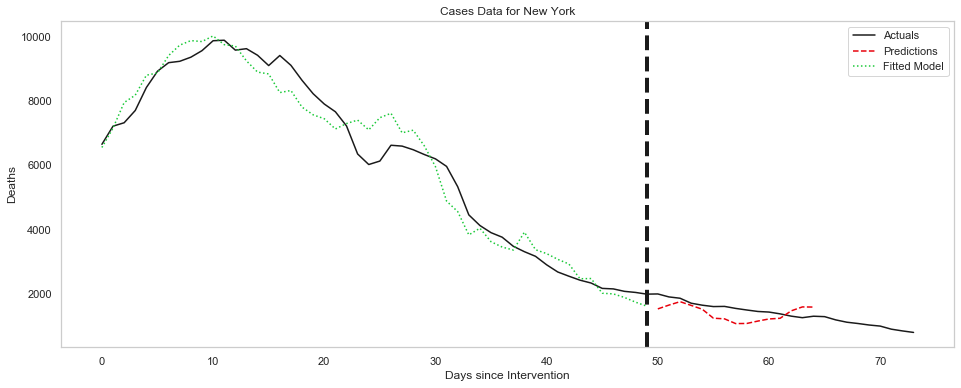

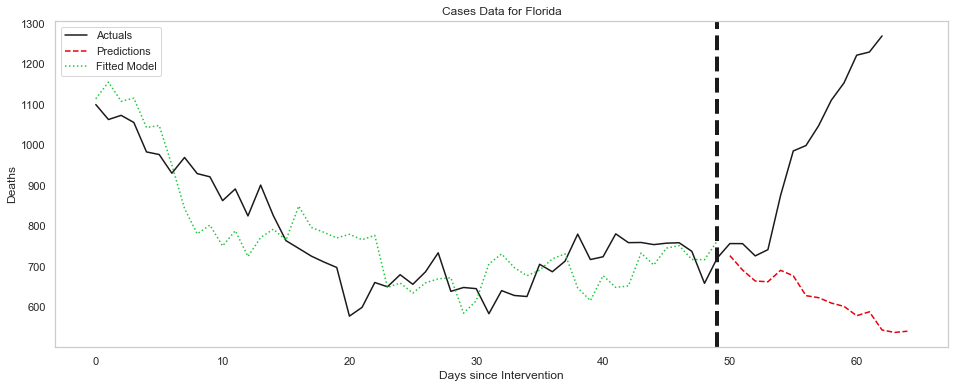

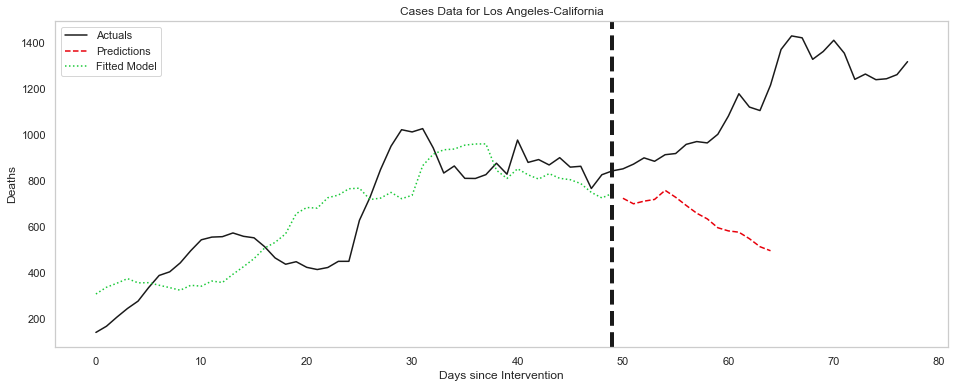

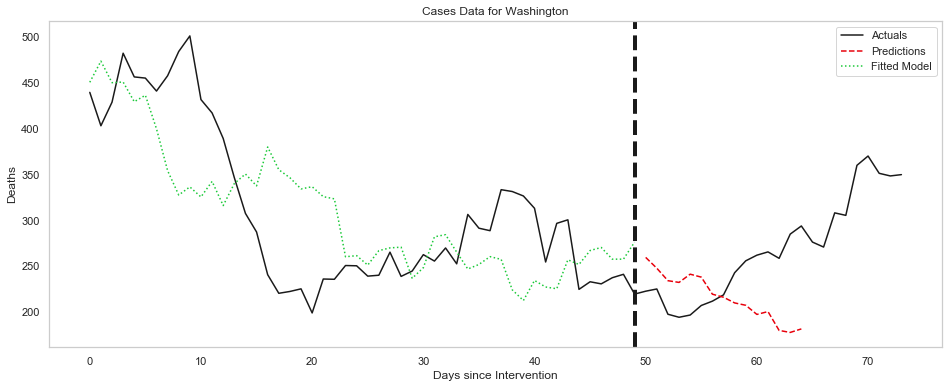

In [21]:
df = deaths_intervention_adjusted_daily
df = df[df.columns[(df>10).any()]].copy()

df1 = cases_intervention_adjusted_daily[df.columns].copy()

high_thresh = 70
low_thresh = 50

sizes = df[targets].apply(pd.Series.last_valid_index)
donorpool = sizes[sizes>=high_thresh].index

targets = ['Arizona','Connecticut', 'Texas', 'New Jersey','California', 'Massachusetts', 'Pennsylvania', 'New York', 'Florida', 'Los Angeles-California', 'Washington']
donors = ['Washington', 'Massachusetts', 'New York', 'Rhode Island', 'New Jersey', 'Pennsylvania', 'Delaware', 'Virginia', 'Connecticut']
singVals = 3
weight_features = []
move_intervention = 10
i=1
for target in targets:
  
    try:
        newdata = synth_control_predictions([df1],high_thresh, low_thresh,
                                            "Cases Data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[target], donorPool=donors, svdSpectrum=False, silent=True, showDonors=False, showPlots=True, mRSC=False, error_thresh = 10)
        weight_features.append(newdata)
        i=i+1
    except ValueError:
        print(target)
        continue